In [43]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
#from src.projects.eurosat.architecture import

In [3]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('eurosat')

In [31]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:80%]", "train[80%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

In [38]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

2022-12-02 10:20:41.489803: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


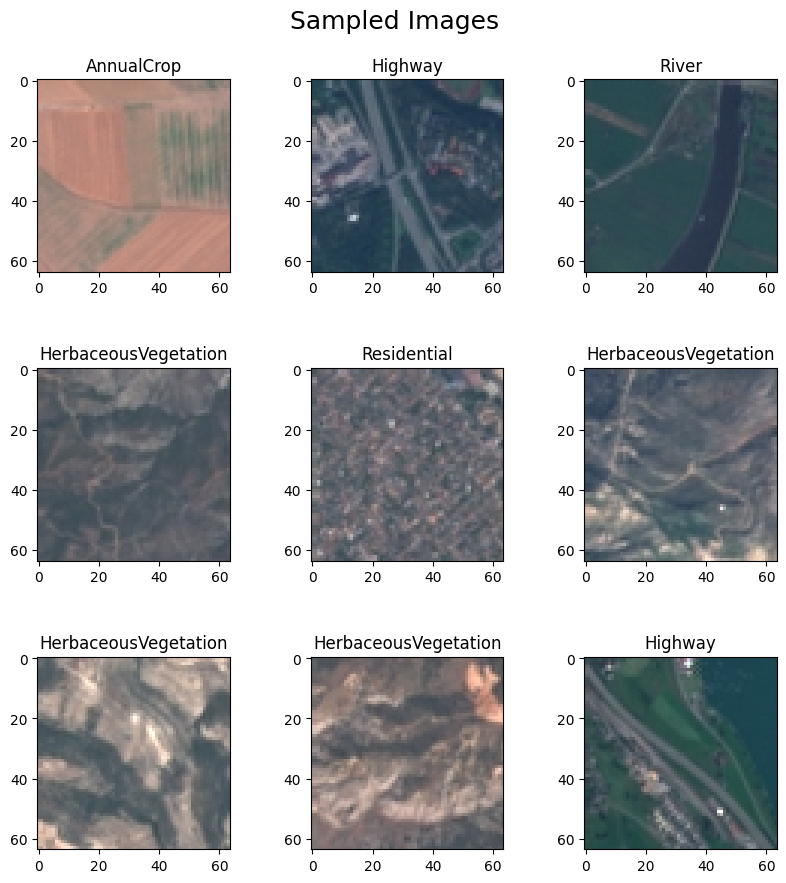

In [64]:
random_images = []

for el in train_dataset.shuffle(1000).take(9):
    image, label = el
    label_name = class_names[label.numpy()]
    random_images.append((label_name, image))

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sampled Images", fontsize=18, y=0.95)

for img_tuple, ax in zip(random_images, axs.ravel()):
    label, img = img_tuple
    ax.imshow(img)
    ax.set_title(label)
plt.show()